## CSCA 5632 Unsupervised Algorithms in Machine Learning Final Project
#### Sean Diab
#### 11/20/2024
#### GitHub Repo Link: https://github.com/Sean-Diab/CSCA-5632-Unsupervised-Learning-Final-Project.git
The goal of this project is to find topics and patterns in data from various AI/ML related subreddits. I will download the data using the PRAW (Python Reddit API Wrapper) library. After this, I will clean the data, perform EDA (Exploratory Data Analysis), use Latent Dirichlet Allocation (LDA) to find patterns and topics in the data, and analyze/visualize the results. As a bonus, I also use the data to fine-tune DistilGPT-2, a lighter version of GPT-2.

Imports:

In [2]:
import contractions
from datetime import datetime
import json
import praw
import pyLDAvis
import pyLDAvis.lda_model
import re
import spacy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import textwrap

from collections import Counter
from datasets import Dataset, load_from_disk
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, pipeline
from wordcloud import WordCloud


### Step 1. Gathering the Data using PRAW (Python Reddit API Wrapper)

PRAW downloads Reddit posts from most recent to least recent. For each of the subreddits, there was a point after roughly 700-900 posts downloaded where there wasn't any more data for that specific subreddit.  
Using these insights, my code iterates through each subreddit name in the 'subreddits' array and downloads as much data as it can. The files get saved to /data/subreddits/'subreddit_name'.json, so each subreddit gets saved to its own specific file.  
This code took me roughly two hours to run for all the subreddits. I ran it on a separate python file, so you won't be able to see the output for the code in this notebook. When I ran it, I set the 'limit' variable to 1000. The limit variable controls how many posts will be downloaded. It is currently set to 10.

In [ ]:
reddit = praw.Reddit(
    client_id='', #Use your id
    client_secret='', #Use your secret
    user_agent='RedditScraper'
)

# List of subreddits to scrape
subreddits = [
    'MachineLearning',
    'learnmachinelearning',
    'artificial',
    'ArtificialInteligence',
    'deeplearning',
    'computervision',
    'singularity'
]

def fetch_data(subreddit_name, limit, output_file):
    subreddit = reddit.subreddit(subreddit_name)
    counter = 1

    print(f"Downloading the most recent {limit} posts from r/{subreddit_name}...")

    start_time = time.time()

    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('[\n')  #Start the JSON array

        for submission in subreddit.new(limit=limit):
            if counter % 10 == 0:
                elapsed_time = time.time() - start_time
                print(f'{counter} out of {limit} downloaded at {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}. Time elapsed: {elapsed_time:.2f} seconds')

            submission.comments.replace_more(limit=None)
            comments = [comment.body for comment in submission.comments.list()]

            submission_data = {
                'submission_id': submission.id,
                'title': submission.title,
                'selftext': submission.selftext,
                'created_utc': datetime.fromtimestamp(submission.created_utc).isoformat(),
                'num_comments': submission.num_comments,
                'comments': comments
            }

            json.dump(submission_data, f, ensure_ascii=False, indent=4)
            f.write(',\n')

            time.sleep(0.5)  #Reddit lets you download 100 queries per minute, so increase this delay if you're going too fast.
            counter += 1

        f.write('\n]')

    
    with open(output_file, 'r', encoding='utf-8') as f:
        content = f.read()

    #Remove the leftover comma in the bottom of the JSON file
    fixed_content = re.sub(r',\s*([\]\}])', r'\1', content)

    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(fixed_content)

    print(f"Fixed trailing commas in {output_file}")

    total_time = time.time() - start_time
    minutes = total_time / 60
    print(f"Finished downloading {counter - 1} posts from r/{subreddit_name}. Total time taken: {total_time:.2f} seconds or {minutes:.2f} minutes\n")
    return counter - 1

for subreddit_name in subreddits:
    output_file = f'data/subreddits/{subreddit_name}.json'
    limit = 10  # Number of posts to fetch per subreddit, set to 1000 to download full data. No subreddit will download more than 1000 posts before it runs out of data.
    fetch_data(subreddit_name, limit, output_file)


10 out of 10 downloaded at 2024-11-21 04:34:39. Time elapsed: 6.83 seconds
Fixed trailing commas in data/subreddits/MachineLearning.json
Finished downloading 10 posts from r/MachineLearning. Total time taken: 7.52 seconds or 0.13 minutes

10 out of 10 downloaded at 2024-11-21 04:34:46. Time elapsed: 6.29 seconds
Fixed trailing commas in data/subreddits/learnmachinelearning.json
Finished downloading 10 posts from r/learnmachinelearning. Total time taken: 6.97 seconds or 0.12 minutes

10 out of 10 downloaded at 2024-11-21 04:34:53. Time elapsed: 6.46 seconds
Fixed trailing commas in data/subreddits/artificial.json
Finished downloading 10 posts from r/artificial. Total time taken: 7.27 seconds or 0.12 minutes

10 out of 10 downloaded at 2024-11-21 04:35:00. Time elapsed: 6.71 seconds
Fixed trailing commas in data/subreddits/ArtificialInteligence.json
Finished downloading 10 posts from r/ArtificialInteligence. Total time taken: 7.70 seconds or 0.13 minutes

10 out of 10 downloaded at 2024-

### Merging the Files
I now merge all of the files together into one file called '1.combined_sorted.json'. For the next steps of data cleaning I will order files numerically, with this file being number 1.

In [6]:
file_paths = [f'data/subreddits/{subreddit}.json' for subreddit in subreddits]

combined_data = []

for file_name in file_paths:
    print('file name:', file_name)
    with open(file_name, 'r', encoding='utf-8') as file:  #Use utf-8 encoding, default encoding didn't work
        data = json.load(file)
        combined_data.extend(data)

#Sort the combined data by date
combined_data.sort(key=lambda x: datetime.fromisoformat(x['created_utc']), reverse=True)

# Save the sorted data to a new JSON file
with open('data/1.combined_sorted.json', 'w', encoding='utf-8') as file:
    json.dump(combined_data, file, indent=4)

print(f"Combined and sorted JSON data saved to 'data/1.combined_sorted.json'.")

file name: data/subreddits/MachineLearning.json
file name: data/subreddits/learnmachinelearning.json
file name: data/subreddits/artificial.json
file name: data/subreddits/ArtificialInteligence.json
file name: data/subreddits/deeplearning.json
file name: data/subreddits/computervision.json
file name: data/subreddits/singularity.json
Combined and sorted JSON data saved to 'data/1.combined_sorted.json'.


### Flatten the Data

This cell combines 'title' and 'selftext' (the text inside of the post). It also Flattens all of the comments into a single string. The result gets saved to /data/flattened_data.json.


In [7]:
with open('data/1.combined_sorted.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

flattened_data = []
for submission in data:
    #Combine title and selftext into one text
    main_text = f"{submission.get('title', '')} {submission.get('selftext', '')}"

    #Flatten comments into a single string
    comments_flattened = " ".join(submission.get("comments", []))

    flattened_data.append({
        "combined_text": main_text,
        "comments_flattened": comments_flattened,
        "created_utc": submission.get("created_utc"),
        "num_comments": submission.get("num_comments"),
    })

with open("data/2.flattened_data.json", "w") as file:
    json.dump(flattened_data, file, indent=4)

print("Flatened data saved to 'data/2.flattened_data.json'.")

Flatened data saved to 'data/2.flattened_data.json'.


### Remove Flair
Some Reddit posts have a flair, which is a tag at the beginning of the title that can look like [D]. It is usually a single letter between two square brackets. I decided to get rid of these, since I will clean all extra symbols, which will just leave a misplaced letter at the start of some posts. The output gets saved to ./data/3.removed_flair_data.json.

In [8]:
with open("data/2.flattened_data.json", "r") as file:
    data = json.load(file)

for entry in data:
    #Use regex to remove a single letter between brackets at the start of combined_text
    entry["combined_text"] = re.sub(r"^\[\w\]\s*", "", entry["combined_text"])

with open("data/3.removed_flair_data.json", "w") as file:
    json.dump(data, file, indent=4)

print("Data with removed flairs saved to 'data/3.removed_flair_data.json'.")

Data with removed flairs saved to 'data/3.removed_flair_data.json'.


### Expand Contractions
This cell will expand contractions (ex: you've to you have). The output gets saved to /data/4.removed_contractions_data.json.

In [9]:
with open("data/3.removed_flair_data.json", "r") as file:
    data = json.load(file)

for record in data:
    #Expand contractions in "combined_text"
    record["combined_text"] = contractions.fix(record["combined_text"])
    
    #Expand contractions in "comments_flattened"
    record["comments_flattened"] = contractions.fix(record["comments_flattened"])

with open("data/4.removed_contractions_data.json", "w") as file:
    json.dump(data, file, indent=4)

print("Data with expanded contractions saved to 'data/4.removed_contractions_data.json'.")

Data with expanded contractions saved to 'data/4.removed_contractions_data.json'.


### Clean Extra Symbols
This cell wil clean all extra symbols other than letters and numbers. The output gets saved to /data/5.cleaned_data.json.

In [ ]:
with open('data/4.removed_contractions_data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

def clean_text(text):
    #Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    #Remove Markdown links (e.g., [text](link))
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    #Remove special characters and emojis
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    #Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    #Strip leading and trailing spaces
    text = text.strip()
    return text

for entry in data:
    entry["combined_text"] = clean_text(entry.get("combined_text", ""))
    entry["comments_flattened"] = clean_text(entry.get("comments_flattened", ""))

with open("data/5.cleaned_data.json", "w") as file:
    json.dump(data, file, indent=4)


print("Cleaned data saved to 'data/5.cleaned_data.json'.")

Cleaned data saved to 'data/5.cleaned_data.json'.


## Perform Lemmatization  

This cell will perform Lemmatization. Lemmatization removes filler words. For example: "In a new study GPT4o agents achieved 85 accuracy in simulating..." turns into "new study GPT4o agent achieve 85 accuracy simulate". This is useful because the model works with the frequency of words that it sees, and filler words like 'is', 'a', etc. will needlessly complicate things without adding any importance.  
The file gets saved to /data/final_data.json.


To run this cell, make sure you installed the english version of spaCy:  

On windows, run:  
pip install spacy  
python -m spacy download en_core_web_sm  


In [11]:
nlp = spacy.load("en_core_web_sm")

with open("data/5.cleaned_data.json", "r") as file:
    cleaned_data = json.load(file)

def lemmatize_texts(texts, batch_size=1000):
    """
    Lemmatize a list of texts using spaCy's nlp.pipe for batch processing.
    """
    lemmatized_texts = []
    for doc in nlp.pipe(texts, batch_size=batch_size, disable=["ner"]):  # Disable NER to speed up processing
        lemmatized_texts.append(
            " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
        )
    return lemmatized_texts

combined_texts = [entry["combined_text"] for entry in cleaned_data]
comments_texts = [entry["comments_flattened"] for entry in cleaned_data]

print("Lemmatizing 'combined_text' fields...")
lemmatized_combined = lemmatize_texts(combined_texts, batch_size=1000)

print("Lemmatizing 'comments_flattened' fields...")
lemmatized_comments = lemmatize_texts(comments_texts, batch_size=1000)

for i, entry in enumerate(cleaned_data):
    entry["lemmatized_combined_text"] = lemmatized_combined[i]
    entry["lemmatized_comments"] = lemmatized_comments[i]


with open("data/final_data.json", "w") as file:
    json.dump(cleaned_data, file, indent=4)

print(f"Lemmatization complete. Data saved to 'data/final_data.json'.")


Lemmatizing 'combined_text' fields...
Lemmatizing 'comments_flattened' fields...
Lemmatization complete. Data saved to 'data/final_data.json'.


The data is now clean and it is time to start EDA.

### 2. Exploratory Data Analysis (EDA)

In this stage we will analyze the data to understand it more. This will also be useful to compare with the results that the Latent Dirichlet Allocation model gets.

Load the dataframe:

In [3]:
with open("data/final_data.json", "r") as file:
    data = json.load(file)

df = pd.DataFrame(data)

#### Analyze Text Length:

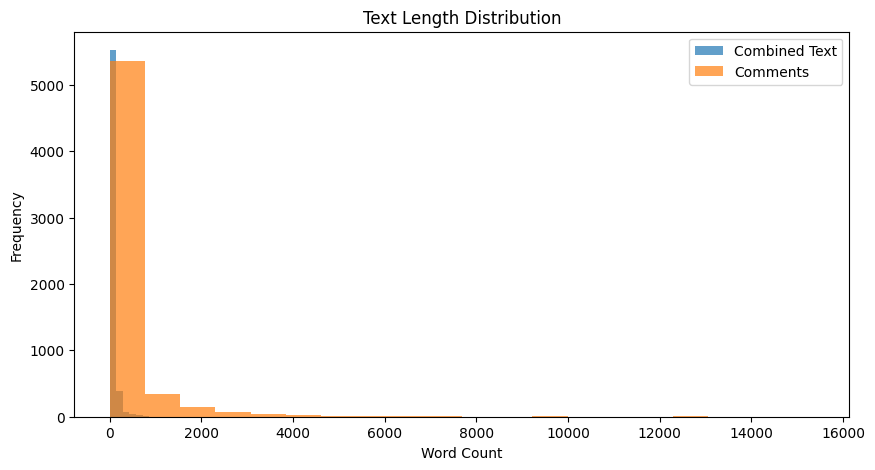

In [13]:
df['combined_text_length'] = df['lemmatized_combined_text'].apply(lambda x: len(x.split()))
df['comments_length'] = df['lemmatized_comments'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
plt.hist(df['combined_text_length'], bins=20, alpha=0.7, label='Combined Text')
plt.hist(df['comments_length'], bins=20, alpha=0.7, label='Comments')
plt.legend()
plt.title("Text Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

The majority of posts have roughly 100 words. Most comments contain roughly 400 words, but can vary much more, which makes sense since some comment sections can have many comments if a post does well.

### Identify Most Frequent Words

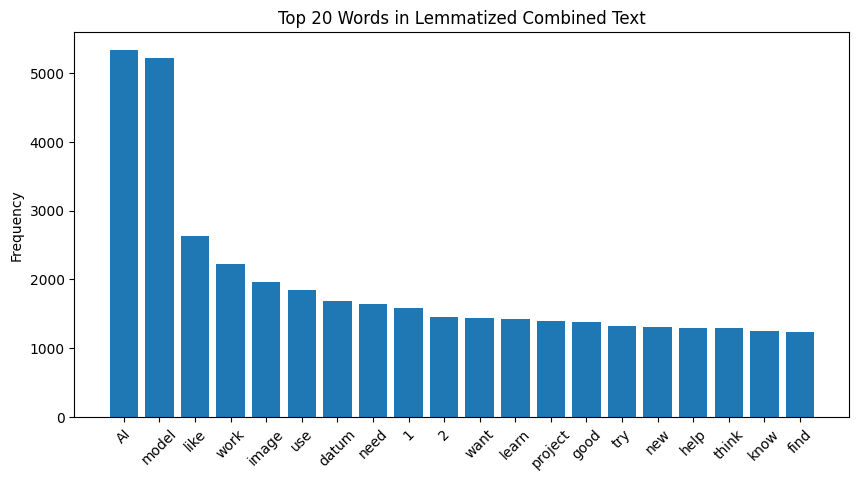

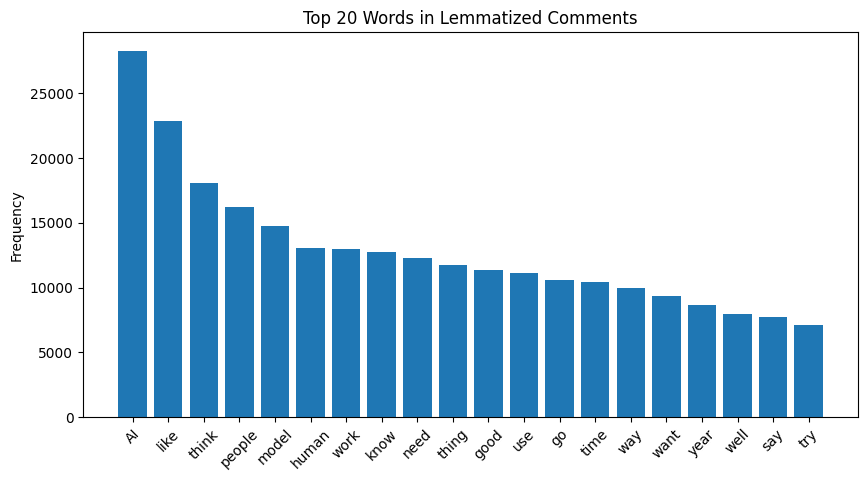

In [14]:
combined_text = " ".join(df['lemmatized_combined_text'])
comments_text = " ".join(df['lemmatized_comments'])

combined_word_counts = Counter(combined_text.split())
comments_word_counts = Counter(comments_text.split())

combined_common = combined_word_counts.most_common(20)
comments_common = comments_word_counts.most_common(20)

def plot_common_words(common_words, title):
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.show()

plot_common_words(combined_common, "Top 20 Words in Lemmatized Combined Text")
plot_common_words(comments_common, "Top 20 Words in Lemmatized Comments")

### Analyze Frequent Bigrams and Trigrams

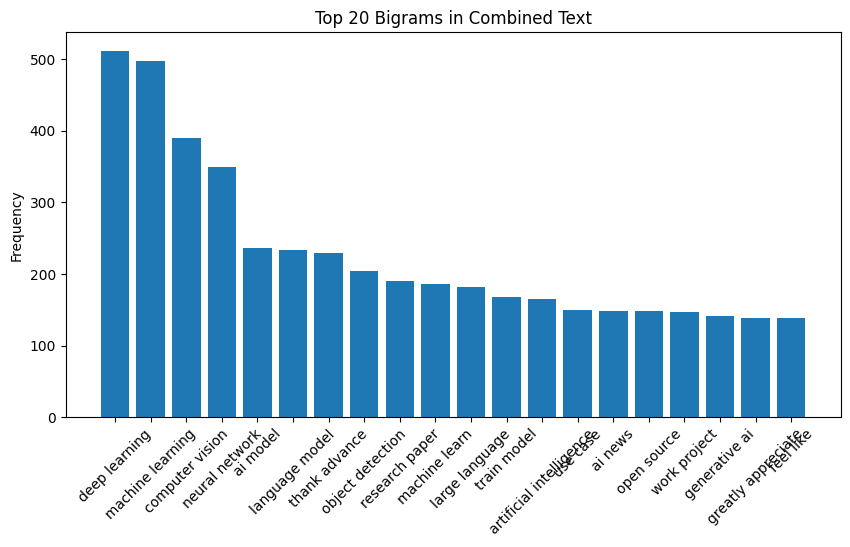

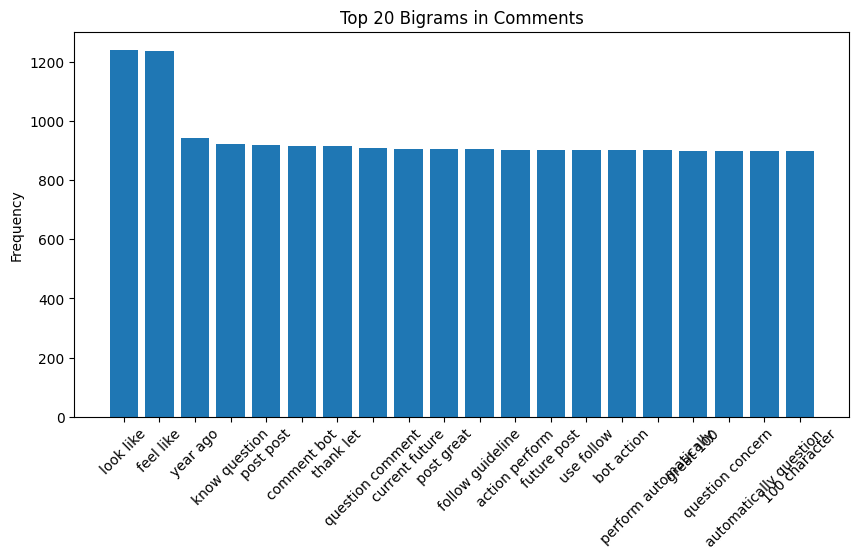

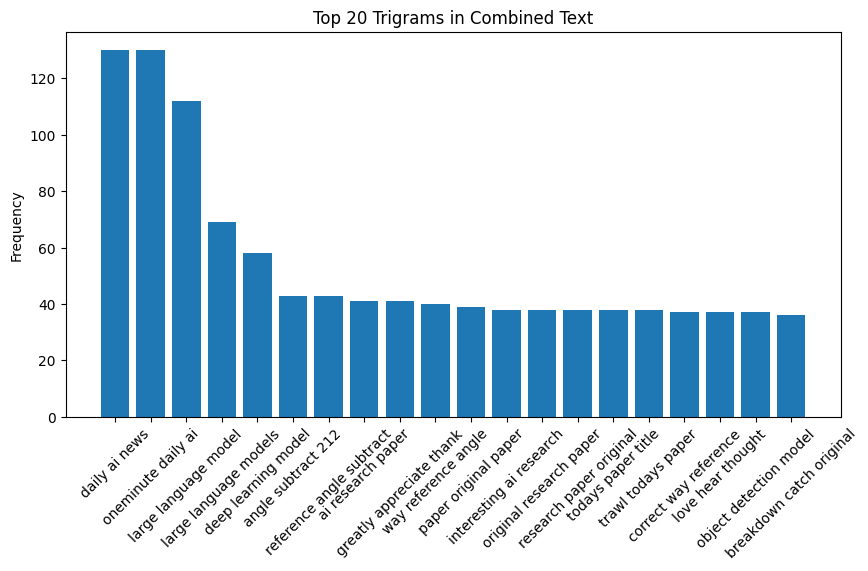

In [15]:
def extract_ngrams(texts, n):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(texts)
    ngram_counts = ngrams.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    return sorted(zip(ngram_features, ngram_counts), key=lambda x: x[1], reverse=True)[:20]

bigrams_combined = extract_ngrams(df['lemmatized_combined_text'], 2)
bigrams_comments = extract_ngrams(df['lemmatized_comments'], 2)

trigrams_combined = extract_ngrams(df['lemmatized_combined_text'], 3)
trigrams_comments = extract_ngrams(df['lemmatized_comments'], 3)

plot_common_words(bigrams_combined, "Top 20 Bigrams in Combined Text")
plot_common_words(bigrams_comments, "Top 20 Bigrams in Comments")

plot_common_words(trigrams_combined, "Top 20 Trigrams in Combined Text") #The trigrams in comments wasn't remarkable so I only plotted for combined text


### Generate Word Clouds

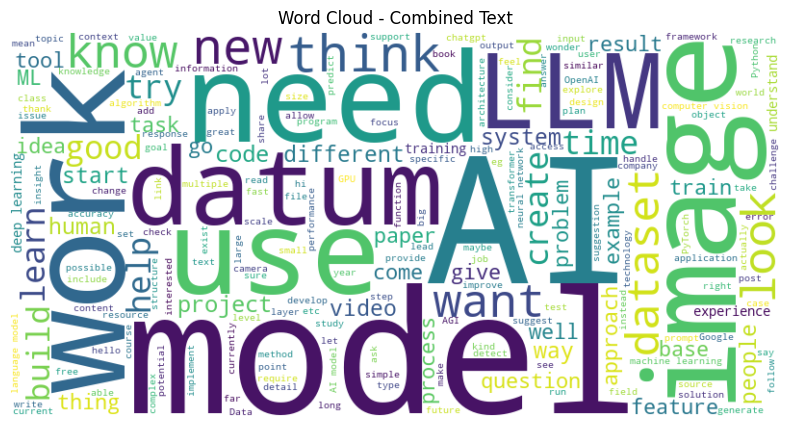

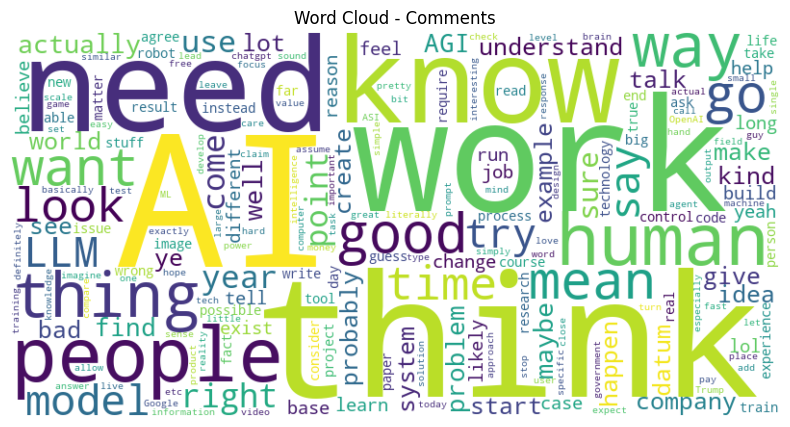

In [16]:
combined_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
comments_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)

plt.figure(figsize=(10, 5))
plt.imshow(combined_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Combined Text")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(comments_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Comments")
plt.show()

### Sentiment Analysis

This analyzes the overall sentiment of the data, which is between -1 and 1. 1 indicates a positive sentiment, and -1 indicates a negative sentiment.

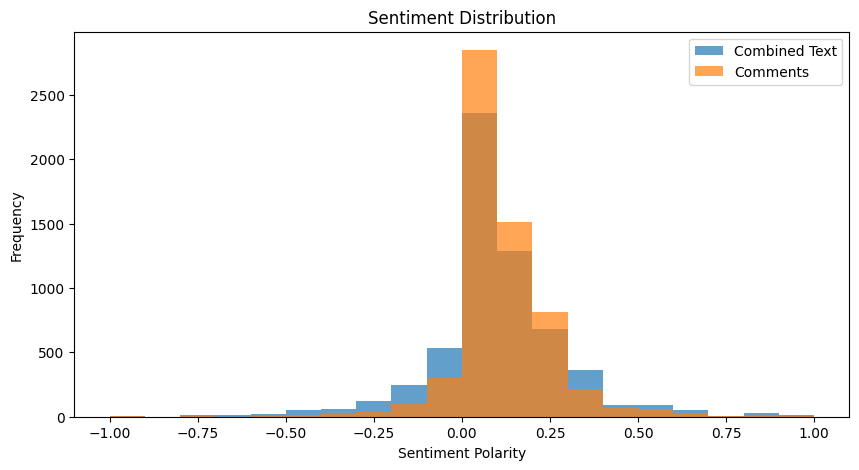

In [17]:
df['combined_sentiment'] = df['lemmatized_combined_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['comments_sentiment'] = df['lemmatized_comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 5))
plt.hist(df['combined_sentiment'], bins=20, alpha=0.7, label='Combined Text')
plt.hist(df['comments_sentiment'], bins=20, alpha=0.7, label='Comments')
plt.legend()
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

### Graph Sentiment Analysis over Time

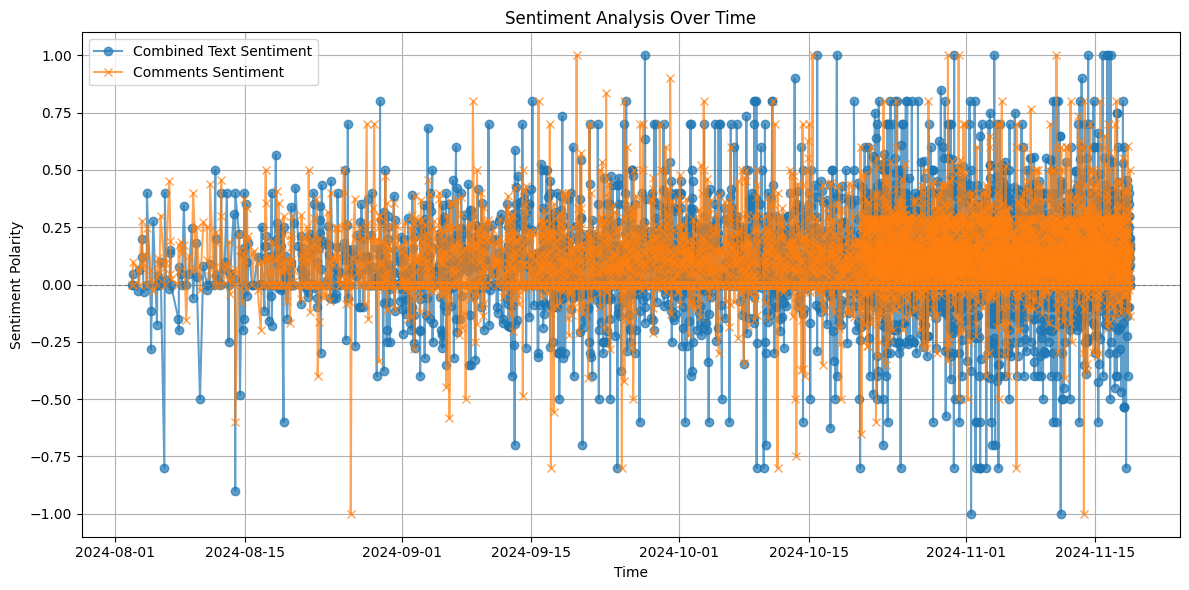

In [18]:
df['created_datetime'] = pd.to_datetime(df['created_utc'])

def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['combined_sentiment'] = df['lemmatized_combined_text'].apply(calculate_sentiment)
df['comments_sentiment'] = df['lemmatized_comments'].apply(calculate_sentiment)

df = df.sort_values(by='created_datetime')

plt.figure(figsize=(12, 6))
plt.plot(df['created_datetime'], df['combined_sentiment'], label='Combined Text Sentiment', marker='o', alpha=0.7)
plt.plot(df['created_datetime'], df['comments_sentiment'], label='Comments Sentiment', marker='x', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Neutral line
plt.title('Sentiment Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Sentiment Polarity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 3. Perform Analysis Using An Unsupervised Learning Model

Now that we've understood the data better, it is time to train our model. I will only be using the data from the title and the posts, since the comments can be much more randomized.

In [4]:
documents = df['lemmatized_combined_text']

### Vectorize the Text and Convert it into Numerical Format

In [5]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english', ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(documents)

feature_names = vectorizer.get_feature_names_out()

Now it is time to use the model to find topics in the data.

### Apply Latent Dirichlet Allocation (LDA)

In [6]:
n_topics = 10 #The amount of topics it will make, you can change this
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)

lda_model.fit(tfidf_matrix)

LatentDirichletAllocation(random_state=42)

The model has now been fit. It has separated the data into what it thinks are the top ten topics.

## Interpret the Results

Extract the top words for each topic.

In [7]:
no_top_words = 10

for topic_idx, topic in enumerate(lda_model.components_, 1):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

Topic 1:
artificial intelligence open source artificial intelligence open ai source dspy grok swarm
Topic 2:
35 diffusion sonnet claude 35 claude prize stable diffusion survey ai stable
Topic 3:
learning machine machine learning course learn ml deep deep learning book job
Topic 4:
loss segmentation epoch class model layer dataset train validation def
Topic 5:
ai openai agi human say news new agent intelligence chatgpt
Topic 6:
model like work ai image project use need good paper
Topic 7:
object camera detection image 3d detect object detection pose yolo estimation
Topic 8:
cat descent gradient descent ilya transformer onnx lens auto transformer architecture drive car
Topic 9:
llm medical removal tumor analysis introduce report image ai event
Topic 10:
gb gpu ram rtx buy laptop gb ram vram gguf 16 gb


We can see clear logic in each topic. Each topic is structured around a unique theme(s).  

Here is my interpretation of each topic based on the top keywords:  
1. Artifical intelligence and open source development
2.  Generative models
3. Machine learning education and careers
4. Model training and validation
5. AGI and the ethics around intelligence
6. Research projects and papers
7. Object detection and computer vision
8. Optimization, and AI development (ONNX stands for Open Neural Network Exchange)
9. AI being used for medical reasons
10. Hardware for AI development


### Evaluate the Model
Calculate coherence:

In [36]:
def extract_sklearn_topics(lda_model, feature_names, num_top_words=10):
    topics = []
    for topic in lda_model.components_:
        top_words_indices = topic.argsort()[:-num_top_words - 1:-1]
        topics.append([feature_names[i] for i in top_words_indices])
    return topics

num_top_words = 10
topics = extract_sklearn_topics(lda_model, feature_names, num_top_words)

texts = [doc.split() for doc in df['lemmatized_combined_text']]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

coherence_model = CoherenceModel(
    topics=topics, 
    texts=texts, 
    dictionary=dictionary, 
    coherence='c_v'  #Use 'u_mass', 'c_v', 'c_uci', or 'c_npmi'
)
coherence_score = coherence_model.get_coherence()

print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.473247720846926


The coherence score seems pretty resonable, especially considering the data is a collection of random people posting across multiple subreddits.


### Create Visualizations

In [8]:
pyLDAvis.enable_notebook()  #Use in Jupyter Notebook
panel = pyLDAvis.lda_model.prepare(lda_model, tfidf_matrix, vectorizer, sort_topics=False)
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.015767  0.000569       1        1   2.207655
1     -0.031740 -0.022366       2        1   3.399522
2     -0.011888 -0.183793       3        1   3.790524
3      0.076496  0.022867       4        1   3.044773
4     -0.225785  0.104582       5        1  14.027561
5      0.012181 -0.027955       6        1  61.661980
6      0.168085  0.115408       7        1   4.741332
7      0.004916 -0.001148       8        1   2.181684
8      0.012450  0.011495       9        1   2.357940
9      0.011053 -0.019659      10        1   2.587030, topic_info=          Term        Freq       Total Category  logprob  loglift
210         ai  246.000000  246.000000  Default  30.0000  30.0000
2299  learning   81.000000   81.000000  Default  29.0000  29.0000
1977     image  109.000000  109.000000  Default  28.0000  28.0000
2282     learn   78.000000   78.000000  Default  27.0000  27.0000
2458   machine   59.000000   59.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
2864    nvidia    4.741416   21.839263  Topic10  -5.0952   2.1273
3025        pc    3.392770    8.878052  Topic10  -5.4298   2.6927
3208       pro    3.875433   16.286472  Topic10  -5.2968   2.2190
1680      game    3.336345   23.771504  Topic10  -5.4466   1.6910
3689    server    2.590105   10.521364  Topic10  -5.6998   2.2530

[547 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
23        4  0.113941      16
23        6  0.227881      16
23       10  0.569703      16
24       10  0.900791   16 gb
55        6  0.328666      2d
...     ...       ...     ...
4591      1  0.075691  yolov8
4591      3  0.075691  yolov8
4591      6  0.227074  yolov8
4591      7  0.605532  yolov8
4594      5  0.926194    yous

[993 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

This won't load in GitHub, I uploaded the HTML file of this interactive visualization to my repo called lda_visualization.html

This graph provides a visualization of how related topics are by using dimensionality reduction to map the high-dimensional relationships onto a 2D space. Topics that are closer together are more related, and vice-versa. The size of a circle reflects the prevalence of the topic in the dataset.

### Visualizing with t-SNE

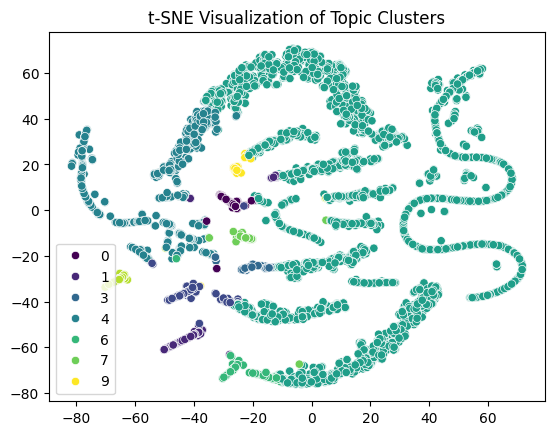

In [38]:
doc_topic_dist = lda_model.transform(tfidf_matrix)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(doc_topic_dist)

sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=np.argmax(doc_topic_dist, axis=1), palette='viridis')
plt.title("t-SNE Visualization of Topic Clusters")
plt.show()


This graph is a t-SNE (t-Distributed Stochastic Neighbor Embedding) visualization of the topic clusters. Similarly to the previous graph, it uses dimensionality reduction to provide a 2D representation of how the topics relate to each other.

## Results
The model seemed to find 10 unique topics contained in the data. All it takes is to read the top ten words from each topic (you can find these by scrolling up to 'Interpret the Results') and we can intuitively understand what the topic is about. Here are the topics and my interpretation of them again: 

Topic 1:  
artificial intelligence open source artificial intelligence open ai source dspy grok swarm  
Topic 2:  
35 diffusion sonnet claude 35 claude prize stable diffusion survey ai stable  
Topic 3:  
learning machine machine learning course learn ml deep deep learning book job  
Topic 4:  
loss segmentation epoch class model layer dataset train validation def  
Topic 5:  
ai openai agi human say news new agent intelligence chatgpt  
Topic 6:  
model like work ai image project use need good paper  
Topic 7:  
object camera detection image 3d detect object detection pose yolo estimation  
Topic 8:  
cat descent gradient descent ilya transformer onnx lens auto transformer architecture drive car  
Topic 9:  
llm medical removal tumor analysis introduce report image ai event  
Topic 10:  
gb gpu ram rtx buy laptop gb ram vram gguf 16 gb  

My interpretation: 
1. Artifical intelligence and open source development
2.  Generative models
3. Machine learning education and careers
4. Model training and validation
5. AGI and the ethics around intelligence
6. Research projects and papers
7. Object detection and computer vision
8. Optimization, and AI development (ONNX stands for Open Neural Network Exchange)
9. AI being used for medical reasons
10. Hardware for AI development


We can see a quantitative evaluation of this by looking at the coherence score of 0.47. This demonstrates moderate success, especially considering how crazy Reddit posts and comments must be to classify.

## Conclusion
In this project, we identified and summarized the main topics in various AI/ML related subreddits using unsupervised topic modeling techniques. We collected the data using an API and cleaned it. After that, we did some exploratory data analysis to understand it. Then we used Latent Dirichlet Allocation to extract ten topics from the data.  

To visualize the relationships between the topics, we used interactive dimensionality reduction tools such as PyLDAvis and t-SNE. These visualizations gave us insights on how distinct or overlapped the data points are. Finally, we evaluated how well the model organized the data into topics.  

While the model preformed resonably well with a moderate coherence score, it showed us the challenges of using topic modeling to analyze chaotic and noisy datasets like Reddit discussions.

## Bonus: Turn the data into an LLM

I was curious to see if I could turn the data I had into an LLM that only talks about AI. With a GeForce RTX 2070 Super and a dream, I decided to fine-tune DistilGPT-2 (a lighter version of GPT-2) on the data I had.   To do this, I combined the posts and the comments together here. I made two files, one with the complete data and one that only had 1000 posts so it would train more quickly.

In [39]:
with open('final_data.json', 'r') as f:
    data = json.load(f)

simplified_data = []
for entry in data:
    combined_text = entry.get('combined_text', '').strip()
    comments_flattened = entry.get('comments_flattened', '').strip()
    
    if combined_text or comments_flattened:
        combined_entry = f"{combined_text}\n\n{comments_flattened}"
        simplified_data.append(combined_entry)

with open('data/llm/fine_tuning_corpus_complete.txt', 'w') as f:
    for text in simplified_data:
        f.write(text.strip() + "\n")

with open('data/llm/fine_tuning_corpus_1000.txt', 'w') as f:
    for text in simplified_data[:1000]:
        f.write(text.strip() + "\n")

print("Files created: 'fine_tuning_corpus_complete.txt' and 'fine_tuning_corpus_1000.txt'")

Files created: 'fine_tuning_corpus_complete.txt' and 'fine_tuning_corpus_1000.txt'


### Download and Prepare DistilGPT-2

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

dataset = Dataset.from_text("./data/llm/fine_tuning_corpus_complete.txt")

def tokenize_function(examples):
    tokens = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.save_to_disk("./data/llm/tokenized_reddit_data")

### Fine-Tune DistilGPT-2 by Training it on My Data
This took 13 hours to run and I ran it in a separate Python file.

In [41]:
activate = False #If you really want to run this cell, set this to True. This took me 13 hours.

if activate:
    tokenized_dataset = load_from_disk("./data/llm/tokenized_reddit_data")

    model = AutoModelForCausalLM.from_pretrained("distilgpt2")

    training_args = TrainingArguments(
        output_dir="./distilgpt2-reddit-finetuned",
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=4,
        save_steps=500,
        save_total_limit=2,
        logging_dir="./logs",
        logging_steps=100,
        evaluation_strategy="no",
        warmup_steps=500,
        learning_rate=5e-5,
        weight_decay=0.01,
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
    )

    trainer.train()

    trainer.save_model("./data/llm/distilgpt2-reddit-finetuned")
    tokenizer.save_pretrained("./data/llm/distilgpt2-reddit-finetuned")

### Test It
Here you can use the LLM! Change the prompt to whatever you want and run the cell. Using it is free since it runs off of your computer.

In [42]:
generator = pipeline("text-generation", model="./data/llm/distilgpt2-reddit-finetuned")

prompt = "Hi"
output = generator(prompt, max_length=300, truncation=True, num_return_sequences=1) #Adjust max_length as needed
generated_text = output[0]["generated_text"]

formatted_text = textwrap.fill(generated_text, width=80)  #Adjust width as needed
print(formatted_text)

Hi you cannot trust me when discussing new research you cannot trust me when
discussing new research you cannot trust me when discussing new research you
cannot trust me when discussing new research you will have to consider a new
paper or something


This is pretty funny, it sounds like if Reddit was a person.